# Does amplicon bias help?
> Let's see if we should even keep this term

Using the experimental amplicon bias term introduced on Nov 29 2022

In [1]:
import sys
sys.path.append('/home/phil/aptr')
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from aptr.simulation_new import make_tables
from aptr.database import RnaDB
from aptr.torch_solver import TorchSolver

plt.rc('font', size=20)

In [3]:
rnadb = RnaDB(
    # path_to_dnaA = "../../data/allDnaA.tsv",
    # path_to_16s = "../../data/allSSU.tsv",
)

0.9992494370778083 sequences remain after trimming
0.6346009507130348 sequences remain after filtering


In [4]:
# Copied from scaling_experiment_matrix.ipynb

def score(solver, true_abundances, true_log2_ptrs):
    inferred_ptrs = pd.DataFrame(
        data=solver.B_hat.exp2().detach().numpy(),
        index=solver.genome_ids,
        columns=solver.sample_ids,
    )
    inferred_abundances = pd.DataFrame(
        data=solver.A_hat.detach().numpy(),
        index=solver.genome_ids,
        columns=solver.sample_ids,
    )
    true_ptrs = np.exp2(true_log2_ptrs).reindex(inferred_ptrs.index)
    true_abundances = true_abundances.reindex(inferred_abundances.index)

    ptr_score = true_ptrs - inferred_ptrs
    abundance_score = true_abundances - inferred_abundances
    return ptr_score, abundance_score, inferred_ptrs, inferred_abundances


In [15]:
# Experiment 1: how much worse is the solution when we have a free bias term?

results = pd.DataFrame()
for multiplier in range(-3, 3):
    scale = 10 ** multiplier
    print(f"Scale: {scale}")
    abundances, log2_ptrs, otus = make_tables(
        db=rnadb,
        n_samples=20,
        n_genomes=10,
        sparsity=0,
        multiplier=scale
    )
    for bias in [True, False]:
        solver = TorchSolver(otus=otus, db=rnadb)
        solver.train(lr=0.1, clip=True, model_bias=bias)
        ptr_score, abundance_score, inferred_ptrs, inferred_abundances = score(
            solver=solver, true_abundances=abundances, true_log2_ptrs=log2_ptrs
        )
        for i, genome_id in enumerate(solver.genome_ids):
            for j, sample_id in enumerate(solver.sample_ids):
                try:
                    results = results.append({
                        "scale": scale,
                        "bias": bias,
                        "genome": genome_id,
                        "sample": sample_id,
                        "ptr_true": np.exp2(log2_ptrs.loc[genome_id, sample_id]),
                        "ptr_inferred": inferred_ptrs.loc[genome_id, sample_id],
                        "ptr_score": ptr_score.loc[genome_id, sample_id],
                        "abundance_true": abundances.loc[genome_id, sample_id],
                        "abundance_inferred": inferred_abundances.loc[genome_id, sample_id],
                        "abundance_score": abundance_score.loc[genome_id, sample_id],
                    }, ignore_index=True)
                except KeyError:
                    print(f"==============KeyError: {genome_id}, {sample_id}")


Scale: 0.001
Using OTU index for md5s
Initial:	 0.896958589553833
Epoch 0:	 0.05611050873994827
Epoch 1:	 0.0561181902885437
Epoch 2:	 0.056111376732587814
Epoch 3:	 0.05611620843410492
Epoch 4:	 0.056112341582775116
Epoch 5:	 0.05611409246921539
Epoch 6:	 0.05619199573993683
Using OTU index for md5s
Initial:	 0.896958589553833
Epoch 0:	 0.0659143254160881
Epoch 1:	 0.06591431051492691
Epoch 2:	 0.06591471284627914
Epoch 3:	 0.06599265336990356
Epoch 4:	 0.06593234091997147
Epoch 5:	 0.06592047214508057
Epoch 6:	 0.06592443585395813
Epoch 7:	 0.06597431749105453
Scale: 0.01
Using OTU index for md5s
Initial:	 0.7084067463874817
Epoch 0:	 -6.536978721618652
Epoch 1:	 -6.536953449249268
Epoch 2:	 -6.536962985992432
Epoch 3:	 -6.53693962097168
Epoch 4:	 -6.536937713623047
Epoch 5:	 -6.5369553565979
Epoch 6:	 -6.536972999572754
Using OTU index for md5s
Initial:	 0.7084067463874817
Epoch 0:	 -6.519301414489746
Epoch 1:	 -6.525475978851318
Epoch 2:	 -6.525660037994385
Epoch 3:	 -6.52567148208

Text(0.5, 1.0, 'Biased vs. unbiased PTR error vs. scale, unbiased reads case')

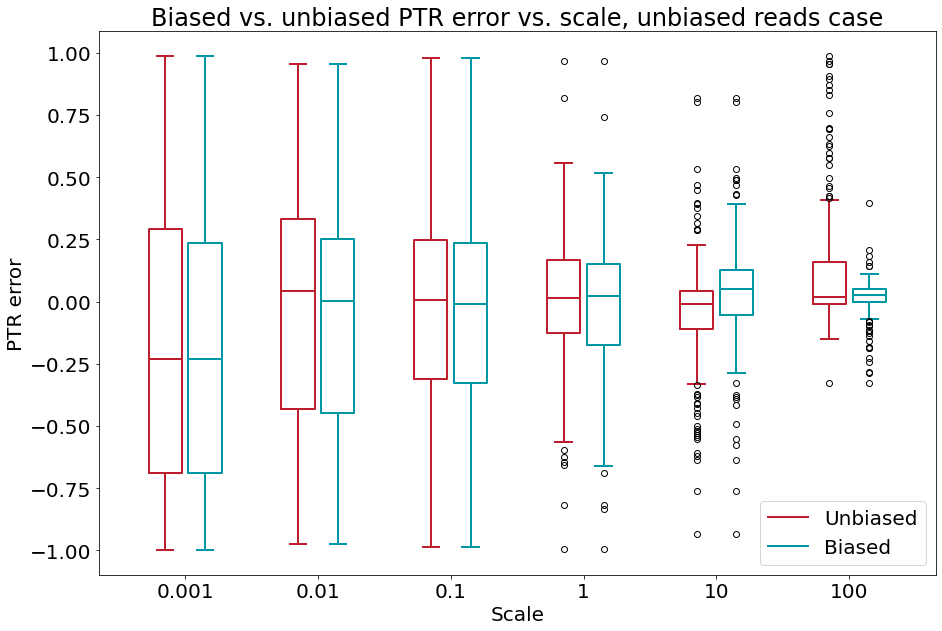

In [17]:
fig = plt.figure(figsize=(15, 10))

# Make data
for_boxplot_unbiased = results[results["bias"] == False]
for_boxplot_bias = results[results["bias"] == True]
x1 = [for_boxplot_unbiased[for_boxplot_unbiased["scale"] == 10**i]["ptr_score"] for i in range(-3, 3)]
x2 = [for_boxplot_bias[for_boxplot_bias["scale"] == 10**i]["ptr_score"] for i in range(-3, 3)]

# Plot
bp1 = plt.boxplot(x1, positions=[1, 2, 3, 4, 5, 6], widths=0.25)
bp2 = plt.boxplot(x2, positions=[1.3, 2.3, 3.3, 4.3, 5.3, 6.3], widths=0.25)
plt.xticks([1.15, 2.15, 3.15, 4.15, 5.15, 6.15], [10**i for i in range(-3, 3)])
plt.xlabel("Scale")
plt.ylabel("PTR error")
plt.title("PTR error vs. scale, MSE vs. Poisson")

# Change colors for medians
for b, c in zip([bp1, bp2], ["#BE1E2D", "#0097A7"]):
    for prop in ["medians", "boxes", "whiskers", "caps", "fliers"]:
        for x in b[prop]:
            x.set(color=c, linewidth=2)

plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ["Unbiased", "Biased"], loc="lower right")
plt.title("Biased vs. unbiased PTR error vs. scale, unbiased reads case")


In [7]:
# Experiment 2: how much worse is the solution when we have a free bias term AND bias?

results = pd.DataFrame()
for multiplier in range(-3, 3):
    scale = 10 ** multiplier
    print(f"Scale: {scale}")
    abundances, log2_ptrs, otus = make_tables(
        db=rnadb,
        n_samples=20,
        n_genomes=10,
        sparsity=0,
        multiplier=scale
    )
    # Add per-md5 bias term
    otus = otus.multiply(np.random.rand(otus.shape[0]), axis=0) 
    for bias in [True, False]:
        solver = TorchSolver(otus=otus, db=rnadb)
        solver.train(lr=0.1, clip=True, model_bias=bias)
        ptr_score, abundance_score, inferred_ptrs, inferred_abundances = score(
            solver=solver, true_abundances=abundances, true_log2_ptrs=log2_ptrs
        )
        for i, genome_id in enumerate(solver.genome_ids):
            for j, sample_id in enumerate(solver.sample_ids):
                try:
                    results = results.append({
                        "scale": scale,
                        "bias": bias,
                        "genome": genome_id,
                        "sample": sample_id,
                        "ptr_true": np.exp2(log2_ptrs.loc[genome_id, sample_id]),
                        "ptr_inferred": inferred_ptrs.loc[genome_id, sample_id],
                        "ptr_score": ptr_score.loc[genome_id, sample_id],
                        "abundance_true": abundances.loc[genome_id, sample_id],
                        "abundance_inferred": inferred_abundances.loc[genome_id, sample_id],
                        "abundance_score": abundance_score.loc[genome_id, sample_id],
                    }, ignore_index=True)
                except KeyError:
                    print(f"==============KeyError: {genome_id}, {sample_id}")


Scale: 0.001
Using OTU index for md5s
Initial:	 1.2963953018188477
Epoch 0:	 0.2788310945034027
Epoch 1:	 0.27533218264579773
Epoch 2:	 0.41648784279823303
Epoch 3:	 0.4116009473800659
Epoch 4:	 0.42583170533180237
Epoch 5:	 0.4252641797065735
Epoch 6:	 0.42432719469070435
Epoch 7:	 0.4228310286998749
Using OTU index for md5s
Initial:	 1.2963953018188477
Epoch 0:	 0.3683815002441406
Epoch 1:	 0.3680447041988373
Epoch 2:	 0.36744043231010437
Epoch 3:	 0.3675345778465271
Epoch 4:	 0.3647341728210449
Epoch 5:	 0.3619019091129303
Epoch 6:	 0.35727840662002563
Epoch 7:	 0.3497162461280823
Epoch 8:	 0.339221715927124
Epoch 9:	 0.32935237884521484
Epoch 10:	 0.3220931887626648
Epoch 11:	 0.3324422836303711
Epoch 12:	 0.33092033863067627
Epoch 13:	 0.33082136511802673
Epoch 14:	 0.3308650851249695
Epoch 15:	 0.3308252990245819
Epoch 16:	 0.3308156728744507
Scale: 0.01
Using OTU index for md5s
Initial:	 1.0706348419189453
Epoch 0:	 -1.3816912174224854
Epoch 1:	 -1.385063886642456
Epoch 2:	 -1.3

Text(0.5, 1.0, 'Biased vs. unbiased PTR error vs. scale, biased reads case')

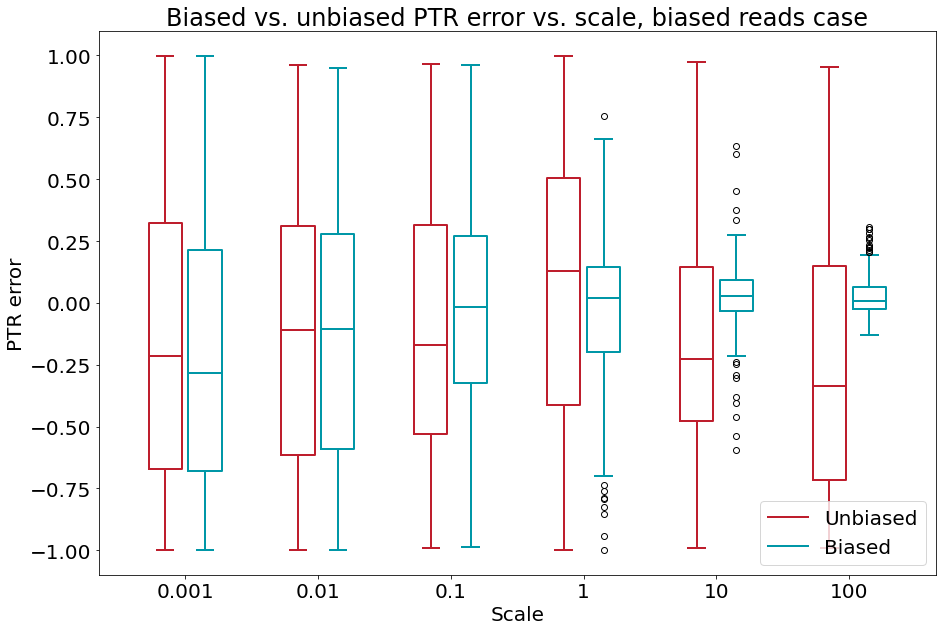

In [13]:
fig = plt.figure(figsize=(15, 10))

# Make data
for_boxplot_unbiased = results[results["bias"] == False]
for_boxplot_bias = results[results["bias"] == True]
x1 = [for_boxplot_unbiased[for_boxplot_unbiased["scale"] == 10**i]["ptr_score"] for i in range(-3, 3)]
x2 = [for_boxplot_bias[for_boxplot_bias["scale"] == 10**i]["ptr_score"] for i in range(-3, 3)]

# Plot
bp1 = plt.boxplot(x1, positions=[1, 2, 3, 4, 5, 6], widths=0.25)
bp2 = plt.boxplot(x2, positions=[1.3, 2.3, 3.3, 4.3, 5.3, 6.3], widths=0.25)
plt.xticks([1.15, 2.15, 3.15, 4.15, 5.15, 6.15], [10**i for i in range(-3, 3)])
plt.xlabel("Scale")
plt.ylabel("PTR error")

# Change colors for medians
for b, c in zip([bp1, bp2], ["#BE1E2D", "#0097A7"]):
    for prop in ["medians", "boxes", "whiskers", "caps", "fliers"]:
        for x in b[prop]:
            x.set(color=c, linewidth=2)

plt.legend([bp1["boxes"][0], bp2["boxes"][0]], ["Unbiased", "Biased"], loc="lower right")
plt.title("Biased vs. unbiased PTR error vs. scale, biased reads case")
